<a href="https://colab.research.google.com/github/aayushmanda/da6401_assignment3/blob/main/asg3_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import random
import re
from prettytable import PrettyTable
import matplotlib.pyplot as plt

In [ ]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
!tar -xvf dakshina_dataset_v1.0.tar


--2025-05-19 15:31:08--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   240MB/s    in 14s     

2025-05-19 15:31:22 (138 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]

dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shuf.txt.gz


In [ ]:
# Define a dataset class for transliteration data
class TransliterationDataset(Dataset):
    def __init__(self, data_path, input_lang, target_lang, max_len=50):
        """
        Args:
            data_path: Path to the data file with pairs of words
            input_lang: The input language/script processor object
            target_lang: The target language/script processor object
            max_len: Maximum sequence length
        """
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.max_len = max_len
        self.pairs = []

        # Load data
        with open(data_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    # Format may vary depending on dataset
                    latin, native = parts[0], parts[1]
                    if latin and native and len(latin) <= max_len and len(native) <= max_len:
                        self.pairs.append((latin, native))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        latin_word, native_word = self.pairs[idx]

        # Convert characters to indices
        input_tensor = self.input_lang.word_to_tensor(latin_word, self.max_len)
        target_tensor = self.target_lang.word_to_tensor(native_word, self.max_len)

        return input_tensor, target_tensor




In [ ]:

# Language class to handle character-level processing
class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {"PAD": 0, "SOS": 1, "EOS": 2}
        self.char2count = {}
        self.index2char = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_chars = 3  # Count PAD, SOS and EOS

    def add_word(self, word):
        for char in word:
            self.add_char(char)

    def add_char(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

    def word_to_tensor(self, word, max_len):
        """Convert a word to tensor of character indices with padding"""
        indices = [self.char2index.get(char, 0) for char in word]
        indices = [self.char2index["SOS"]] + indices + [self.char2index["EOS"]]

        # Pad sequence to max_len
        if len(indices) < max_len + 2:  # +2 for SOS and EOS
            indices += [self.char2index["PAD"]] * (max_len + 2 - len(indices))
        else:
            indices = indices[:max_len + 2]

        return torch.tensor(indices, dtype=torch.long)


In [ ]:

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:

# Function to prepare data for a language pair
def prepare_data(data_path, max_len=50, input_lang=None, output_lang=None): # Add input_lang and output_lang arguments with default None
    if input_lang is None:  # If not provided, create new Lang objects
        input_lang = Lang("latin")
    if output_lang is None:
        output_lang = Lang("native")

    # Read data and build vocabulary
    pairs = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                latin, native = parts[0], parts[1]
                if latin and native and len(latin) <= max_len and len(native) <= max_len:
                    input_lang.add_word(latin)
                    output_lang.add_word(native)
                    pairs.append((latin, native))

    print(f"Prepared {len(pairs)} pairs")
    print(f"Input vocabulary size: {input_lang.n_chars}")
    print(f"Output vocabulary size: {output_lang.n_chars}")

    return input_lang, output_lang, pairs

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, cell_type="LSTM"):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type

        self.embedding = nn.Embedding(input_size, hidden_size)

        if cell_type == "LSTM":
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        else:  # Default to vanilla RNN
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)

    def forward(self, input_seq, hidden):
        # input_seq shape: [batch_size, seq_len]
        batch_size = input_seq.size(0)

        embedded = self.embedding(input_seq)  # [batch_size, seq_len, hidden_size]
        output, hidden = self.rnn(embedded, hidden)

        return output, hidden

    def init_hidden(self, batch_size, device):
        if self.cell_type == "LSTM":
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
        else:
            return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, cell_type="LSTM"):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.cell_type = cell_type

        self.embedding = nn.Embedding(output_size, hidden_size)

        # Attention layers: Wa and Ua for alignment scoring, Va for final score
        self.Wa = nn.Linear(hidden_size, hidden_size)  # For decoder hidden state
        self.Ua = nn.Linear(hidden_size, hidden_size)  # For encoder outputs
        self.Va = nn.Linear(hidden_size, 1)  # Final attention score

        if cell_type == "LSTM":
            self.rnn = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True)  # Input size doubled due to context vector concatenation
        elif cell_type == "GRU":
            self.rnn = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        else:
            self.rnn = nn.RNN(hidden_size * 2, hidden_size, num_layers, batch_first=True)

        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_seq, hidden, encoder_outputs):
        # input_seq shape: [batch_size, 1]
        # encoder_outputs shape: [batch_size, seq_len, hidden_size]
        batch_size = input_seq.size(0)
        seq_len = encoder_outputs.size(1)

        embedded = self.embedding(input_seq)  # [batch_size, 1, hidden_size]

        # Get the current decoder hidden state for attention query
        if self.cell_type == "LSTM":
            query = hidden[0][-1].unsqueeze(1)  # Last layer's hidden state: [batch_size, 1, hidden_size]
        else:
            query = hidden[-1].unsqueeze(1)  # Last layer's hidden state for non-LSTM

        # Compute attention scores
        # Repeat query to match encoder_outputs length for scoring
        query = query.repeat(1, seq_len, 1)  # [batch_size, seq_len, hidden_size]
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(encoder_outputs)))  # [batch_size, seq_len, 1]
        scores = scores.squeeze(2).unsqueeze(1)  # [batch_size, 1, seq_len]

        # Compute attention weights using softmax
        attn_weights = torch.softmax(scores, dim=-1)  # [batch_size, 1, seq_len]

        # Compute context vector as weighted sum of encoder outputs
        context = torch.bmm(attn_weights, encoder_outputs)  # [batch_size, 1, hidden_size]

        # Concatenate context with embedded input for RNN
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, hidden_size * 2]

        # Pass through RNN
        output, hidden = self.rnn(rnn_input, hidden)

        # Compute output probabilities
        output = self.softmax(self.out(output))  # [batch_size, 1, output_size]

        return output, hidden, attn_weights


class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_size

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        # Tensor to store attention weights for visualization (optional)
        attentions = torch.zeros(batch_size, trg_len, src.size(1)).to(self.device)

        # Initialize encoder hidden state
        encoder_hidden = self.encoder.init_hidden(batch_size, self.device)

        # Encode the source sequence
        encoder_outputs, encoder_hidden = self.encoder(src, encoder_hidden)

        # First decoder input is the SOS token
        decoder_input = torch.tensor([[1]] * batch_size, device=self.device)  # SOS token
        decoder_hidden = encoder_hidden

        for t in range(1, trg_len):
            # Pass through decoder with attention over encoder_outputs
            if isinstance(self.decoder, AttentionDecoderRNN):
                decoder_output, decoder_hidden, attn_weights = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                attentions[:, t:t+1, :] = attn_weights
            else:
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

            # Store prediction
            outputs[:, t:t+1, :] = decoder_output

            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = decoder_output.argmax(2)

            # Use teacher forcing or not
            decoder_input = trg[:, t:t+1] if teacher_force else top1

        return outputs, attentions if isinstance(self.decoder, AttentionDecoderRNN) else None




In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device, train_lossi):
    model.train()
    epoch_loss = 0

    for batch_idx, (src, trg) in enumerate(dataloader):
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        # Forward pass (now returns outputs and possibly attentions)
        output, _ = model(src, trg)

        # Reshape for loss calculation
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)  # Skip SOS token
        trg = trg[:, 1:].reshape(-1)  # Skip SOS token

        # Calculate loss
        loss = criterion(output, trg)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        epoch_loss += loss.item()
        train_lossi.append(loss.item())

    return epoch_loss / len(dataloader), train_lossi

def evaluate(model, dataloader, criterion, device, val_lossi):
    model.eval()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)

            output, _ = model(src, trg, teacher_forcing_ratio=0)

            # Reshape for loss calculation
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)  # Skip SOS token
            trg = trg[:, 1:].reshape(-1)  # Skip SOS token

            # Calculate loss
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            val_lossi.append(loss.item())

            # Calculate accuracy
            predictions = output.argmax(1)
            correct_mask = (predictions == trg) & (trg != 0)  # Exclude padding
            correct_predictions += correct_mask.sum().item()
            total_mask = trg != 0  # Exclude padding
            total_predictions += total_mask.sum().item()

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return epoch_loss / len(dataloader), accuracy, val_lossi


In [ ]:
def transliterate(model, src, input_lang, output_lang, device, max_length=100):
    model.eval()
    with torch.no_grad():
        # Reshape input to have batch size of 1
        src = src.unsqueeze(0)  # Add a batch dimension
        src = src.to(device)

        # Initialize hidden state with batch_size=1
        batch_size = 1
        encoder_hidden = model.encoder.init_hidden(batch_size, device)

        # Encoder forward pass
        encoder_outputs, encoder_hidden = model.encoder(src, encoder_hidden)

        # Decoder
        decoder_input = torch.tensor([[1]], device=device)  # SOS token
        decoder_hidden = encoder_hidden
        output_chars = []
        attentions = []

        for _ in range(max_length):
            if isinstance(model.decoder, AttentionDecoderRNN):
                decoder_output, decoder_hidden, attn_weights = model.decoder(decoder_input, decoder_hidden, encoder_outputs)
                attentions.append(attn_weights.squeeze(1).cpu())
            else:
                decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)

            _, topi = decoder_output.topk(1)
            char_idx = topi.item()

            if char_idx == 2:  # EOS token
                break
            output_chars.append(output_lang.index2char[char_idx])
            decoder_input = torch.tensor([[char_idx]], device=device)

        return ''.join(output_chars), attentions if attentions else None


In [ ]:
def main():
    # Parameters (same as your code)
    batch_size = 64
    hidden_size = 256
    learning_rate = 0.001
    num_epochs = 3
    cell_type = "LSTM"
    num_layers = 2
    data_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
    val_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
    test_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Prepare data (same as your code)
    input_lang, output_lang, train_pairs = prepare_data(data_path)
    _, _, val_pairs = prepare_data(val_path, input_lang=input_lang, output_lang=output_lang)
    _, _, test_pairs = prepare_data(test_path, input_lang=input_lang, output_lang=output_lang)

    # Create datasets and dataloaders (same as your code)
    train_dataset = TransliterationDataset(data_path, input_lang, output_lang)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TransliterationDataset(val_path, input_lang, output_lang)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataset = TransliterationDataset(test_path, input_lang, output_lang)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Create model with AttentionDecoderRNN
    encoder = EncoderRNN(input_lang.n_chars, hidden_size, num_layers, cell_type)
    decoder = AttentionDecoderRNN(hidden_size, output_lang.n_chars, num_layers, cell_type)  # Use attention decoder
    model = Seq2SeqModel(encoder, decoder, device).to(device)
    count_parameters(model)

    # Define loss function and optimizer (same as your code)
    criterion = nn.NLLLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop (same structure, updated functions handle attention)
    best_val_loss = float('inf')
    train_lossi = []
    val_lossi = []

    for epoch in range(num_epochs):
        train_loss, train_lossi = train_epoch(model, train_loader, optimizer, criterion, device, train_lossi)
        val_loss, val_accuracy, val_lossi = evaluate(model, val_loader, criterion, device, val_lossi)
        print(f"Epoch: {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_transliteration_model.pt")
            print("Model saved!")
        print("-----")

    # Plot losses (same as your code)
    plt.figure(figsize=(10, 5))
    plt.plot(train_lossi, label='Training Loss')
    plt.plot(val_lossi, label='Validation Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Per-Batch Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    model.load_state_dict(torch.load("attention.pt"))
    test_loss, test_accuracy, _ = evaluate(model, test_loader, criterion, device, [])
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Example transliteration with attention visualization
    for i in range(min(10, len(test_dataset))):
        src, trg = test_dataset[i]
        src_text = ''.join([input_lang.index2char[idx.item()] for idx in src if idx.item() > 2])
        trg_text = ''.join([output_lang.index2char[idx.item()] for idx in trg if idx.item() > 2])

        pred_text, attentions = transliterate(model, src, input_lang, output_lang, device)

        print(f"Input: {src_text}")
        print(f"Target: {trg_text}")
        print(f"Prediction: {pred_text}")
        print("-----")


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29
+--------------------------+------------+
|         Modules          | Parameters |
+--------------------------+------------+
| encoder.embedding.weight |   16896    |
| encoder.rnn.weight_ih_l0 |   262144   |
| encoder.rnn.weight_hh_l0 |   262144   |
|  encoder.rnn.bias_ih_l0  |    1024    |
|  encoder.rnn.bias_hh_l0  |    1024    |
| encoder.rnn.weight_ih_l1 |   262144   |
| encoder.rnn.weight_hh_l1 |   262144   |
|  encoder.rnn.bias_ih_l1  |    1024    |
|  encoder.rnn.bias_hh_l1  |    1024    |
| decoder.embedding.weight |    7424    |
|    decoder.Wa.weight     |   65536    |
|     decoder.Wa.bias      |    256     |
|    decoder.Ua.weight     |   65536    |
|     decoder.Ua.bias      |    256     |
|    decoder.Va.weight     |    256     |
|    

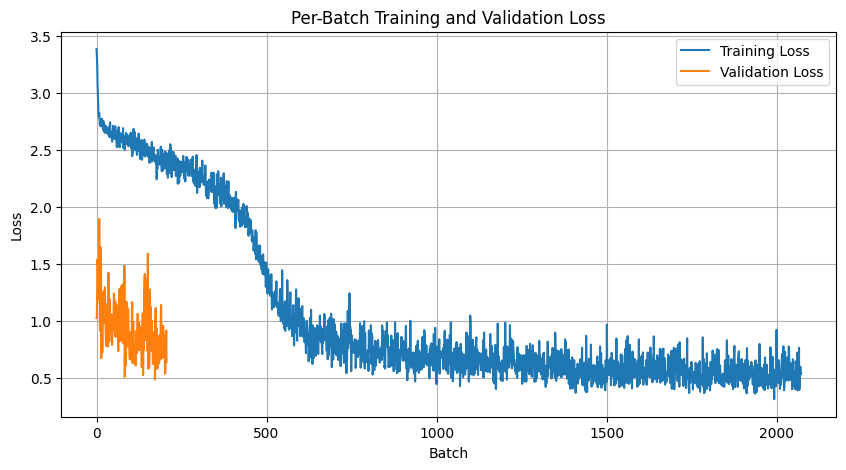

Test Loss: 0.8411
Test Accuracy: 0.7446
Input: अंक
Target: ank
Prediction: ank
-----
Input: अंक
Target: anka
Prediction: ank
-----
Input: अंकित
Target: ankit
Prediction: ankit
-----
Input: अंकों
Target: anakon
Prediction: ankon
-----
Input: अंकों
Target: ankhon
Prediction: ankon
-----
Input: अंकों
Target: ankon
Prediction: ankon
-----
Input: अंकोर
Target: angkor
Prediction: ankor
-----
Input: अंकोर
Target: ankor
Prediction: ankor
-----
Input: अंगारक
Target: angaarak
Prediction: angarak
-----
Input: अंगारक
Target: angarak
Prediction: angarak
-----


In [ ]:
main()

In [ ]:

# Parameters (same as your code)
batch_size = 64
hidden_size = 256
learning_rate = 0.001
num_epochs = 5
cell_type = "LSTM"
num_layers = 2
data_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
val_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
test_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare data (same as your code)
input_lang, output_lang, train_pairs = prepare_data(data_path)
_, _, val_pairs = prepare_data(val_path, input_lang=input_lang, output_lang=output_lang)
_, _, test_pairs = prepare_data(test_path, input_lang=input_lang, output_lang=output_lang)

# Create datasets and dataloaders (same as your code)
train_dataset = TransliterationDataset(data_path, input_lang, output_lang)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TransliterationDataset(val_path, input_lang, output_lang)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_dataset = TransliterationDataset(test_path, input_lang, output_lang)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Create model with AttentionDecoderRNN
encoder = EncoderRNN(input_lang.n_chars, hidden_size, num_layers, cell_type)
decoder = AttentionDecoderRNN(hidden_size, output_lang.n_chars, num_layers, cell_type)  # Use attention decoder
model = Seq2SeqModel(encoder, decoder, device).to(device)
count_parameters(model)

# Define loss function and optimizer (same as your code)
criterion = nn.NLLLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



# Evaluate on test set
# model.load_state_dict(torch.load("attention.pt"))
model.load_state_dict(torch.load("attention.pt"))



Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29
+--------------------------+------------+
|         Modules          | Parameters |
+--------------------------+------------+
| encoder.embedding.weight |   16896    |
| encoder.rnn.weight_ih_l0 |   262144   |
| encoder.rnn.weight_hh_l0 |   262144   |
|  encoder.rnn.bias_ih_l0  |    1024    |
|  encoder.rnn.bias_hh_l0  |    1024    |
| encoder.rnn.weight_ih_l1 |   262144   |
| encoder.rnn.weight_hh_l1 |   262144   |
|  encoder.rnn.bias_ih_l1  |    1024    |
|  encoder.rnn.bias_hh_l1  |    1024    |
| decoder.embedding.weight |    7424    |
|    decoder.Wa.weight     |   65536    |
|     decoder.Wa.bias      |    256     |
|    decoder.Ua.weight     |   65536    |
|     decoder.Ua.bias      |    256     |
|    decoder.Va.weight     |    256     |
|    

<All keys matched successfully>

In [ ]:
!wget -O Mangal.ttf https://raw.githubusercontent.com/ovidiuch/gutenHashTag/master/fonts/mangal.ttf

--2025-05-19 15:32:35--  https://raw.githubusercontent.com/ovidiuch/gutenHashTag/master/fonts/mangal.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144744 (141K) [application/octet-stream]
Saving to: ‘Mangal.ttf’

Mangal.ttf          100%[===================>] 141.35K  --.-KB/s    in 0.02s   

2025-05-19 15:32:35 (6.93 MB/s) - ‘Mangal.ttf’ saved [144744/144744]



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from IPython.display import HTML, display

def color_attention(text, attn_weights, cmap="Reds"):
    """
    text: input string (list of characters)
    attn_weights: attention weights (1D list or numpy array)
    """
    norm = mcolors.Normalize(vmin=min(attn_weights), vmax=max(attn_weights))
    color_map = cm.get_cmap(cmap)

    html = ""
    for char, weight in zip(text, attn_weights):
        rgba = color_map(norm(weight))
        color = mcolors.to_hex(rgba)
        html += f"<span style='background-color:{color}'>{char}</span>"
    return html


In [ ]:
def visualize_attention_matrix(input_chars, output_chars, attention_matrix):
    """
    attention_matrix: shape (len(output_chars), len(input_chars))
    """
    for i, output_char in enumerate(output_chars):
        html = color_attention(input_chars, attention_matrix[i])
        display(HTML(f"<b>{output_char}</b>: {html}"))


Input: अंक
Target: ank
Prediction: ank


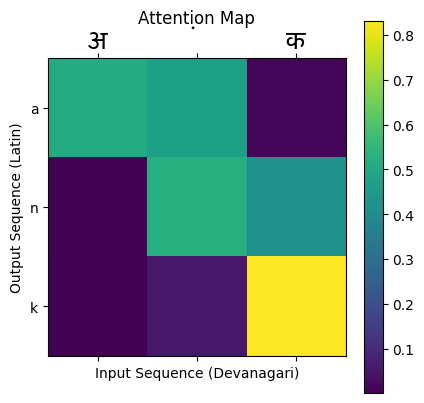

-----
Input: अट्टहास
Target: atthas
Prediction: attahas


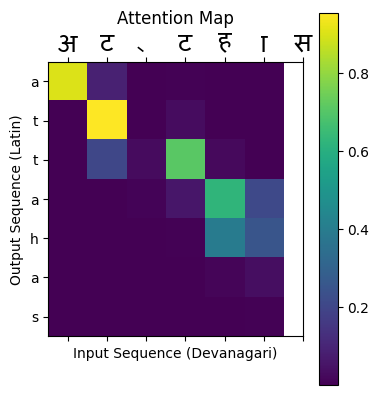

-----
Input: अब्बासी
Target: abbaasi
Prediction: abbasi


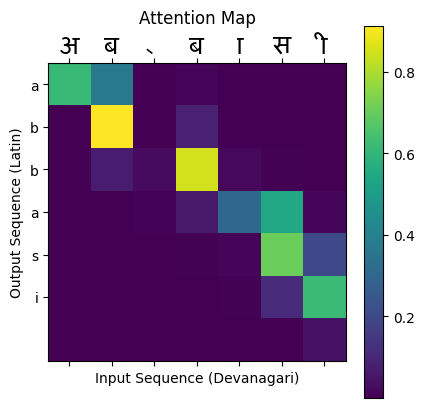

-----
Input: अली
Target: ali
Prediction: ali


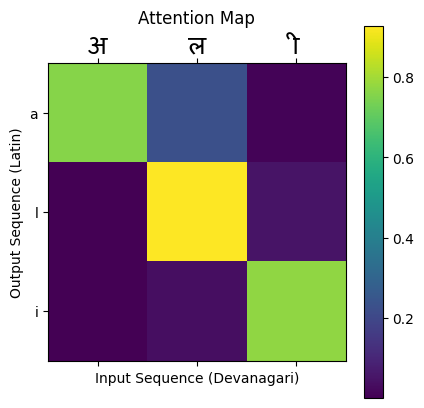

-----
Input: आईपीसी
Target: ipc
Prediction: ipc


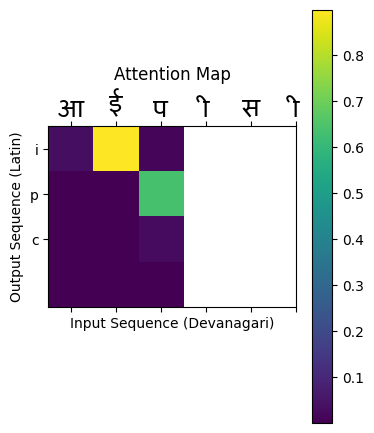

-----
Input: आर्डर
Target: order
Prediction: arder


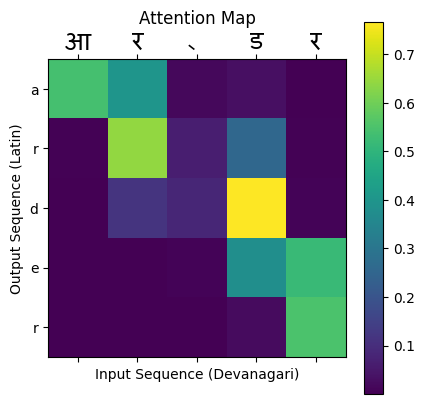

-----


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
import warnings
warnings.filterwarnings('ignore')

# Load the font
font_path = 'Mangal.ttf'
font_prop = FontProperties(fname=font_path, size=18)

for batch_idx, (src, trg) in enumerate(test_loader):
    src, trg = src.to(device), trg.to(device)
    # Take the first sequence in the batch
    src_seq, trg_seq = src[0], trg[0]

    # Exclude SOS (1) and EOS (2) tokens
    src_text = ''.join([input_lang.index2char[idx.item()] for idx in src_seq if idx.item() > 2])
    trg_text = ''.join([output_lang.index2char[idx.item()] for idx in trg_seq if idx.item() > 2])

    # Run transliteration
    pred_text, attentions = transliterate(model, src_seq, input_lang, output_lang, device)

    print(f"Input: {src_text}")
    print(f"Target: {trg_text}")
    print(f"Prediction: {pred_text}")
    attn_matrix = np.array(attentions).squeeze(1)
    if attn_matrix.shape[1] > len(src_labels):
      attn_matrix = attn_matrix[:, 1:-1]  # Skip SOS and EOS columns

    visualize_attention_matrix(list(src_text), list(pred_text), attn_matrix[:1+len(src_text),:10+len(trg_text)])

    # Convert attentions to numpy array
    # attn_matrix = np.array([attn.squeeze(1).cpu().numpy() for attn in attentions])  # Shape: [pred_len, src_len]

    # Adjust matrix to match sequence lengths (exclude SOS/EOS if needed)
    # Assume src includes SOS/EOS, so src_len = len(src_text) + 2
    src_labels = list(src_text)  # Devanagari characters
    pred_labels = list(pred_text)  # Latin characters

    # Plot heatmap
    plt.matshow(attn_matrix[:len(src_text),:len(trg_text)])
    plt.colorbar()

    # # Set ticks and labels
    plt.xticks(ticks=np.arange(len(src_labels)), labels=src_labels, fontproperties=font_prop)
    plt.yticks(ticks=np.arange(len(pred_labels)), labels=pred_labels)

    # # Set axis labels with font
    plt.xlabel('Input Sequence (Devanagari)')
    plt.ylabel('Output Sequence (Latin)')
    plt.title('Attention Map')

    plt.show()

    print("-----")
    if batch_idx == 5:
      break


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from IPython.display import HTML, display

def color_attention(text, attn_weights, cmap="Reds"):
    """
    text: input string (list of characters)
    attn_weights: attention weights (1D list or numpy array)
    """
    norm = mcolors.Normalize(vmin=min(attn_weights), vmax=max(attn_weights))
    color_map = cm.get_cmap(cmap)

    html = ""
    for char, weight in zip(text, attn_weights):
        rgba = color_map(norm(weight))
        color = mcolors.to_hex(rgba)
        html += f"<span style='background-color:{color}'>{char}</span>"
    return html


In [ ]:
def visualize_attention_matrix(input_chars, output_chars, attention_matrix):
    """
    attention_matrix: shape (len(output_chars), len(input_chars))
    """
    for i, output_char in enumerate(output_chars):
        html = color_attention(input_chars, attention_matrix[i])
        display(HTML(f"<b>{output_char}</b>: {html}"))


In [ ]:
input_text = list("mushroom")  # source word
output_text = list("मशरूम")   # predicted target word

# Fake attention weights for illustration
import numpy as np
attention_matrix = np.random.rand(len(output_text), len(input_text))

visualize_attention_matrix(input_text, output_text, attention_matrix)


<ipython-input-1-d44c1dc99661>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap(cmap)


In [ ]:
!pip install --upgrade wandb

#Sweep

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, cell_type="LSTM",  dropout=0.0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type

        self.embedding = nn.Embedding(input_size, hidden_size)

        if cell_type == "LSTM":
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers,
                               dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers,
                              dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        else:
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers,
                              dropout=dropout if num_layers > 1 else 0.0, batch_first=True)

    def forward(self, input_seq, hidden):
        # input_seq shape: [batch_size, seq_len]
        batch_size = input_seq.size(0)

        embedded = self.embedding(input_seq)  # [batch_size, seq_len, hidden_size]
        output, hidden = self.rnn(embedded, hidden)

        return output, hidden

    def init_hidden(self, batch_size, device):
        if self.cell_type == "LSTM":
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
        else:
            return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, cell_type="LSTM", dropout = 0.0):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.cell_type = cell_type

        self.embedding = nn.Embedding(output_size, hidden_size)

        # Attention layers: Wa and Ua for alignment scoring, Va for final score
        self.Wa = nn.Linear(hidden_size, hidden_size)  # For decoder hidden state
        self.Ua = nn.Linear(hidden_size, hidden_size)  # For encoder outputs
        self.Va = nn.Linear(hidden_size, 1)  # Final attention score

        if cell_type == "LSTM":
            self.rnn = nn.LSTM(hidden_size*2, hidden_size, num_layers,
                               dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(hidden_size*2, hidden_size, num_layers,
                              dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        else:
            self.rnn = nn.RNN(hidden_size*2, hidden_size, num_layers,
                              dropout=dropout if num_layers > 1 else 0.0, batch_first=True)

        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_seq, hidden, encoder_outputs):
        # input_seq shape: [batch_size, 1]
        # encoder_outputs shape: [batch_size, seq_len, hidden_size]
        batch_size = input_seq.size(0)
        seq_len = encoder_outputs.size(1)

        embedded = self.embedding(input_seq)  # [batch_size, 1, hidden_size]

        # Get the current decoder hidden state for attention query
        if self.cell_type == "LSTM":
            query = hidden[0][-1].unsqueeze(1)  # Last layer's hidden state: [batch_size, 1, hidden_size]
        else:
            query = hidden[-1].unsqueeze(1)  # Last layer's hidden state for non-LSTM

        # Compute attention scores
        # Repeat query to match encoder_outputs length for scoring
        query = query.repeat(1, seq_len, 1)  # [batch_size, seq_len, hidden_size]
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(encoder_outputs)))  # [batch_size, seq_len, 1]
        scores = scores.squeeze(2).unsqueeze(1)  # [batch_size, 1, seq_len]

        # Compute attention weights using softmax
        attn_weights = torch.softmax(scores, dim=-1)  # [batch_size, 1, seq_len]

        # Compute context vector as weighted sum of encoder outputs
        context = torch.bmm(attn_weights, encoder_outputs)  # [batch_size, 1, hidden_size]

        # Concatenate context with embedded input for RNN
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, hidden_size * 2]

        # Pass through RNN
        output, hidden = self.rnn(rnn_input, hidden)

        # Compute output probabilities
        output = self.softmax(self.out(output))  # [batch_size, 1, output_size]

        return output, hidden, attn_weights


class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_size

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        # Tensor to store attention weights for visualization (optional)
        attentions = torch.zeros(batch_size, trg_len, src.size(1)).to(self.device)

        # Initialize encoder hidden state
        encoder_hidden = self.encoder.init_hidden(batch_size, self.device)

        # Encode the source sequence
        encoder_outputs, encoder_hidden = self.encoder(src, encoder_hidden)

        # First decoder input is the SOS token
        decoder_input = torch.tensor([[1]] * batch_size, device=self.device)  # SOS token
        decoder_hidden = encoder_hidden

        for t in range(1, trg_len):
            # Pass through decoder with attention over encoder_outputs
            if isinstance(self.decoder, AttentionDecoderRNN):
                decoder_output, decoder_hidden, attn_weights = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                attentions[:, t:t+1, :] = attn_weights
            else:
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

            # Store prediction
            outputs[:, t:t+1, :] = decoder_output

            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = decoder_output.argmax(2)

            # Use teacher forcing or not
            decoder_input = trg[:, t:t+1] if teacher_force else top1

        return outputs, attentions if isinstance(self.decoder, AttentionDecoderRNN) else None




In [ ]:
# Define the training function to be used by wandb.agent
def sweep():
    # wandb.init() is called by wandb.agent for each run
    wandb.init(project="attention-sweep") # Initialize a new run within the sweep

    config = wandb.config # Access the hyperparameters for this run
    wandb.run.name = f"{config.cell_type}_hs{config.hidden_size}_nl{config.num_layers}_bs{config.batch_size}_lr{config.learning_rate}_do{config.dropout}"


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data paths (can be hardcoded or potentially moved to config if needed)
    data_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
    val_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
    test_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"


    # Prepare data
    input_lang, output_lang, train_pairs = prepare_data(data_path)
    # Reuse input_lang and output_lang for validation and test sets
    _, _, val_pairs = prepare_data(val_path, input_lang=input_lang, output_lang=output_lang)
    _, _, test_pairs = prepare_data(test_path, input_lang=input_lang, output_lang=output_lang)


    # Create datasets and dataloaders
    train_dataset = TransliterationDataset(data_path, input_lang, output_lang)
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True) # Use config for batch size
    val_dataset = TransliterationDataset(val_path, input_lang, output_lang)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size) # Use config for batch size
    test_dataset = TransliterationDataset(test_path, input_lang, output_lang)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size) # Use config for batch size


    # Create model with AttentionDecoderRNN
    encoder = EncoderRNN(
        input_lang.n_chars,
        hidden_size=config.hidden_size,
        num_layers=config.num_layers,
        cell_type=config.cell_type,
        dropout=config.dropout # Pass dropout from config
    )

    decoder = AttentionDecoderRNN(
        hidden_size=config.hidden_size,
        output_size=output_lang.n_chars,
        num_layers=config.num_layers,
        cell_type=config.cell_type,
        dropout=config.dropout # Pass dropout from config
    )

    model = Seq2SeqModel(encoder, decoder, device).to(device)
    # count_parameters(model) # Optional: log parameter count if needed

    # Define loss function and optimizer
    criterion = nn.NLLLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    # Training loop
    best_val_loss = float('inf')
    train_lossi = []
    val_lossi = []

    for epoch in range(config.num_epochs): # Use config for number of epochs
        train_loss, train_lossi = train_epoch(model, train_loader, optimizer, criterion, device, train_lossi)
        val_loss, val_accuracy, val_lossi = evaluate(model, val_loader, criterion, device, val_lossi)

        print(f"Epoch: {epoch+1}/{config.num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Log metrics to wandb
        wandb.log({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "epoch": epoch
        })
        print("-----")


In [ ]:
import wandb
#  Sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'embedding_size': {
            'values': [16, 32, 64, 256]
        },
        'hidden_size': {
            'values': [16, 32, 64, 256]
        },
        'num_layers': {
            'values': [1, 2, 3]
        },
        'cell_type': {
            'values': ['RNN', 'GRU', 'LSTM']
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'learning_rate': {
            'values': [0.001, 0.0005, 0.0001]
        },
        'num_epochs': {
            'value': 5
        }
    }
}

# Run the sweep
wandb.login(key="e6b43dd118f9a14e83fe12c597ad8d06bdfed432")  # Replace this with safer auth if needed
sweep_id = wandb.sweep(sweep_config, project="da6401-assignment3_attention")
wandb.agent(sweep_id, sweep, count=20)
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24s016 (da24s016-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: 9mw3okow
Sweep URL: https://wandb.ai/da24s016-indian-institute-of-technology-madras/da6401-assignment3_attention/sweeps/9mw3okow


wandb: Agent Starting Run: lzr91j84 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_layers: 3


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Epoch: 1/5
Train Loss: 2.8128
Validation Loss: 2.6593
Validation Accuracy: 0.2604
-----
